# Problem Statement 

The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. 

This notebook has following major sections:
- Exploratory data analysis
- Data cleaning
- Text preprocessing
- Feature extraction:
- Training a text classification model
- Building recommendation model 
- Improving the recommendations using the sentiment analysis model
- Deployment of this end to end project with a user interface

In [3]:
# Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import nltk
from wordcloud import WordCloud

In [5]:
import re
from tqdm import tqdm
import time
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [6]:
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

In [7]:
# Importing data
data = pd.read_csv('sample30.csv')
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [317]:
data.shape

(30000, 12)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
id                      30000 non-null object
brand                   30000 non-null object
categories              30000 non-null object
manufacturer            29859 non-null object
name                    30000 non-null object
reviews_date            29954 non-null object
reviews_didPurchase     15932 non-null object
reviews_doRecommend     27430 non-null object
reviews_rating          30000 non-null int64
reviews_text            30000 non-null object
reviews_title           29810 non-null object
reviews_userCity        1929 non-null object
reviews_userProvince    170 non-null object
reviews_username        29937 non-null object
user_sentiment          29999 non-null object
dtypes: int64(1), object(14)
memory usage: 3.4+ MB


In [10]:
data.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'reviews_username', 'user_sentiment'],
      dtype='object')

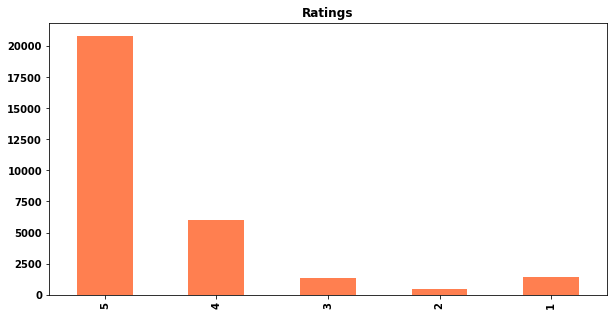

In [11]:
# Checking distribution of Ratings
plt.figure(figsize=(10,5))
data.reviews_rating.value_counts().sort_index(ascending=False).plot(kind='bar',color='coral')
plt.title('Ratings')
plt.show()

Most of customers have given high ratings

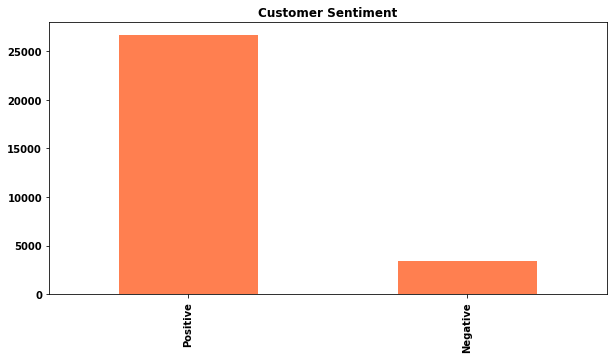

In [12]:
# Checking distribution of Customer sentimentals 

plt.figure(figsize=(10,5))
data.user_sentiment.value_counts().sort_index(ascending=False).plot(kind='bar',color='coral')
plt.title('Customer Sentiment')
plt.show()

- Most users have given postive reviews.
- Above graph also shows class imbalance 

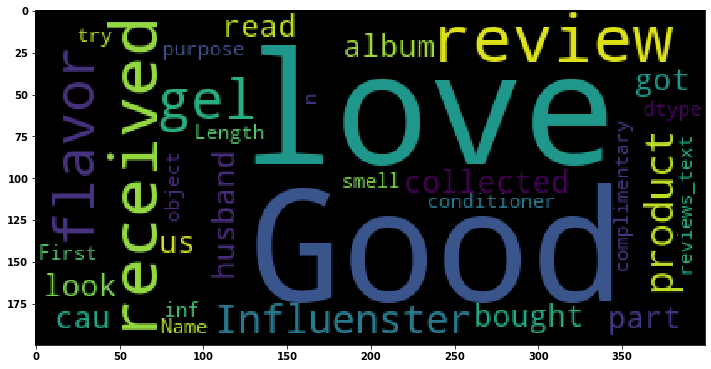

In [13]:
# Ploting most used words in reviews

stop=stopwords.words('english')
wordcloud=WordCloud(stopwords=stop,max_words=100,random_state=100).generate(str(data['reviews_text']))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.show()

## Data Cleaning

In [14]:
data_copy=data.copy()

In [15]:
# Checking columns with null values 
round(data.isnull().sum()/data.shape[0]*100,2)

id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.47
name                     0.00
reviews_date             0.15
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.63
reviews_userCity        93.57
reviews_userProvince    99.43
reviews_username         0.21
user_sentiment           0.00
dtype: float64

In [16]:
# Clearly columns with high missing values are not important for our analysis, therefore we will remove them

data.drop(['reviews_didPurchase','reviews_userCity','reviews_userProvince'],axis=1,inplace=True)

In [17]:
data.shape

(30000, 12)

In [18]:
round(data.isnull().sum()/data.shape[0]*100,2)

id                     0.00
brand                  0.00
categories             0.00
manufacturer           0.47
name                   0.00
reviews_date           0.15
reviews_doRecommend    8.57
reviews_rating         0.00
reviews_text           0.00
reviews_title          0.63
reviews_username       0.21
user_sentiment         0.00
dtype: float64

In [19]:
# Data Quality Checks

print(data.user_sentiment.value_counts())

data[(data.reviews_rating>3) & (data.user_sentiment=='Negative')] # these data points needs to be corrected

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64


,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
92,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-05-26T00:00:00.000Z,True,4,It hydrates my skin. It is not too thick and h...,hydrating but not too heavy,janicec,Negative
96,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-05-26T00:00:00.000Z,True,4,In only a week I can see the difference in my ...,This product has made a real difference on my ...,deedeedeedeesqr,Negative
100,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-05-26T00:00:00.000Z,True,4,This product has made my skin smoother and sup...,Noticed a difference in just two weeks!,ellie3,Negative
106,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-06-02T00:00:00.000Z,True,4,I like to use this cream on my neck and collar...,Very rich cream,kaycoop,Negative
117,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream,2015-06-06T00:00:00.000Z,True,4,I finally found a moisturizing product that wi...,Not greasy,rosaliem2001,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...
29818,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2016-12-21T00:00:00.000Z,NaN,5,I received a complimentary sample of this prod...,Great Product,cindi d,Negative
29855,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-14T00:00:00.000Z,True,5,This has prolonged the color in my hair! Not o...,Great,meghanz,Negative
29858,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2016-12-30T00:00:00.000Z,True,5,This conditioner makes my hair very soft witho...,Makes my hair soft and shiny without excess oil!,melissa7390,Negative
29862,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-18T00:00:00.000Z,True,5,This conditioner has become a staple in my hai...,Great Conditioner,kacils,Negative


In [20]:
def sentiment(x):
    if x>=3:
        return 'Positive'
    else:
        return 'Negative'
    
data['user_sentiment'] = data['reviews_rating'].apply(sentiment)

In [21]:
data.user_sentiment.value_counts()

Positive    28196
Negative     1804
Name: user_sentiment, dtype: int64

## Text Preprocessing

In [22]:
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [23]:
data.reviews_text

0        i love this album. it's very good. more to the...
1        Good flavor. This review was collected as part...
2                                             Good flavor.
3        I read through the reviews on here before look...
4        My husband bought this gel for us. The gel cau...
                               ...                        
29995    I got this conditioner with Influenster to try...
29996    I love it , I received this for review purpose...
29997    First of all I love the smell of this product....
29998    I received this through Influenster and will n...
29999    I received this product complimentary from inf...
Name: reviews_text, Length: 30000, dtype: object

In [24]:
def preprocess(doc):
    
    # Converting text into lowercase
    doc=doc.lower()
    
    # Removing Punctuations and special characters
    doc=re.sub('[^A-Za-z0-9\s]'," ",doc)
    
    # Removing Stop Words
    words=word_tokenize(doc)
    words=[word for word in words if word not in stopwords.words('english')]
    
    # Lemmatizing words 
    wordnet_lemmatizer = WordNetLemmatizer()
    words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
    
    doc=" ".join(words)
    return doc

In [25]:
df=data[['reviews_text','user_sentiment']]
df.head()

,reviews_text,user_sentiment
0,i love this album. it's very good. more to the...,Positive
1,Good flavor. This review was collected as part...,Positive
2,Good flavor.,Positive
3,I read through the reviews on here before look...,Negative
4,My husband bought this gel for us. The gel cau...,Negative


In [26]:
lemmatize_text=[]
for i in tqdm(data.reviews_text):
    lemmatize_text.append(preprocess(i))
    

100%|██████████| 30000/30000 [16:50<00:00, 29.68it/s] 


In [27]:
df['lemmatize_text']=lemmatize_text

In [28]:
df['user_sentiment']=df['user_sentiment'].map({'Negative':0,'Positive':1})

In [29]:
df.head()

,reviews_text,user_sentiment,lemmatize_text
0,i love this album. it's very good. more to the...,1,love album good hip hop side current pop sound...
1,Good flavor. This review was collected as part...,1,good flavor review collect part promotion
2,Good flavor.,1,good flavor
3,I read through the reviews on here before look...,0,read review look buy one couple lubricants ult...
4,My husband bought this gel for us. The gel cau...,0,husband buy gel us gel cause irritation felt l...


In [30]:
df.shape

(30000, 3)

## Feature Extraction

In [31]:
# Dividing dataset into train and test

x_train,x_test,y_train,y_test = train_test_split(df['lemmatize_text'],df['user_sentiment'],train_size=0.7,random_state=101)

# Checking shapes of datasets
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(21000,)
(9000,)
(21000,)
(9000,)


In [32]:
# We are using TF-Idf vectorizer for this assignment

vectorizer=TfidfVectorizer(
    strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step. 
    analyzer='word',            # Whether the feature should be made of word or character n-grams.
    token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'
    ngram_range=(1, 3),         # The lower and upper boundary of the range of n-values for different n-grams to be extracted
    stop_words='english',
    sublinear_tf=True)

vectorizer=vectorizer.fit(x_train)


In [33]:
x_train_transform=vectorizer.transform(x_train)
x_train_transform.shape

(21000, 345471)

In [34]:
# Transforming test data
x_test_transform=vectorizer.transform(x_test)
x_test_transform.shape

(9000, 345471)

In [35]:
# Saving TF-Idf model with pickle

pickle.dump(vectorizer,open('TFidf.pkl','wb'))

In [36]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [37]:
# We know our data is imbalance, therefore here we will use SMOTE handle imbalace dataset

count=Counter(y_train)
print(count)

sampler=SMOTE()
x_train_new,y_train_new=sampler.fit_resample(x_train_transform,y_train)

count=Counter(y_train_new)
print(count)

Counter({1: 19765, 0: 1235})
Counter({1: 19765, 0: 19765})


## Training Text Classification Model

We will make following ML Models :
- Logistic Regression
- Random Forest
- XGBoost
- Naive Bayes

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,classification_report,precision_score,f1_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [39]:
# pip install xgboost

In [40]:
performance_comparison=[]
def model_performance(model_name,y_train_pred,y_test_pred,performance_comparison):
    print('Model Performance on Train Data :')
    print()
    confusion = confusion_matrix(y_train_new,y_train_pred)
    TP = confusion[1,1]
    TN = confusion[0,0]
    FP = confusion[0,1]
    FN = confusion[1,0]
    
    print('Accuracy :',format(accuracy_score(y_train_new,y_train_pred),'.4f'))
    print('ROC Score :',format(roc_auc_score(y_train_new,y_train_pred),'.4f'))
    print('Sensitivity :',format(TP/float(TP+FN),'.4f'))
    print()
    print(classification_report(y_train_new,y_train_pred))
    print('*'*100)
    print('Model Performance on Test Data :')
    print()
    confusion = confusion_matrix(y_test,y_test_pred)
    TP = confusion[1,1]
    TN = confusion[0,0]
    FP = confusion[0,1]
    FN = confusion[1,0]
    print('Accuracy :',format(accuracy_score(y_test,y_test_pred),'.4f'))
    print('ROC Score :',format(roc_auc_score(y_test,y_test_pred),'.4f'))
    print('Sensitivity :',format(TP/float(TP+FN),'.4f'))
    print()
    print(classification_report(y_test,y_test_pred))
    
    performance_comparison.append(dict({'Name':model_name,
                                        'Accuracy':format(accuracy_score(y_test,y_test_pred),'.4f'),
                                        'Sensitivity': format(TP/float(TP+FN),'.4f'),
                                        'Precision':format(precision_score(y_test,y_test_pred),'.4f'),
                                        'F1-Score':format(f1_score(y_test,y_test_pred),'.4f')}))

### Logistic regression

In [41]:
# Initializing Logistic regression
lr=LogisticRegression()
lr.fit(x_train_new,y_train_new)


LogisticRegression()

In [42]:
# Predicting on Training 

y_train_pred = lr.predict(x_train_new)

# Predicting On test data

y_test_pred = lr.predict(x_test_transform)

In [43]:
model_performance('Logistic Regression',y_train_pred,y_test_pred,performance_comparison)

Model Performance on Train Data :

Accuracy : 0.9971
ROC Score : 0.9971
Sensitivity : 0.9947

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19765
           1       1.00      0.99      1.00     19765

    accuracy                           1.00     39530
   macro avg       1.00      1.00      1.00     39530
weighted avg       1.00      1.00      1.00     39530

****************************************************************************************************
Model Performance on Test Data :

Accuracy : 0.9562
ROC Score : 0.8578
Sensitivity : 0.9705

              precision    recall  f1-score   support

           0       0.63      0.75      0.68       569
           1       0.98      0.97      0.98      8431

    accuracy                           0.96      9000
   macro avg       0.81      0.86      0.83      9000
weighted avg       0.96      0.96      0.96      9000



Hyperparameter Tuning

In [44]:
params = {'penalty':['l1','l2'],
         'C':[0.001,0.01,0.05,0.25,0.5,0.75,1,10]}

grid_cv=GridSearchCV(estimator=lr,
            param_grid=params,
            n_jobs=-1,
            verbose=1,
            scoring='accuracy')

grid_cv.fit(x_train_new,y_train_new)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 1, 10],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

In [45]:
lr_best = grid_cv.best_estimator_
lr_best

LogisticRegression(C=10)

In [46]:
grid_cv.best_score_

0.9969896281305337

In [47]:
# Predicting on Training 

y_train_pred = lr_best.predict(x_train_new)

# Predicting On test data

y_test_pred = lr_best.predict(x_test_transform)

model_performance('Logistic Regression Tuned',y_train_pred,y_test_pred,performance_comparison)

Model Performance on Train Data :

Accuracy : 0.9991
ROC Score : 0.9991
Sensitivity : 0.9982

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19765
           1       1.00      1.00      1.00     19765

    accuracy                           1.00     39530
   macro avg       1.00      1.00      1.00     39530
weighted avg       1.00      1.00      1.00     39530

****************************************************************************************************
Model Performance on Test Data :

Accuracy : 0.9647
ROC Score : 0.8468
Sensitivity : 0.9817

              precision    recall  f1-score   support

           0       0.72      0.71      0.72       569
           1       0.98      0.98      0.98      8431

    accuracy                           0.96      9000
   macro avg       0.85      0.85      0.85      9000
weighted avg       0.96      0.96      0.96      9000



### Random Forest

In [49]:
# Innitializing Random Forest

rf=RandomForestClassifier()
rf.fit(x_train_new,y_train_new)

RandomForestClassifier()

In [50]:
# Predicting on Training 

y_train_pred = rf.predict(x_train_new)

# Predicting On test data

y_test_pred = rf.predict(x_test_transform)

model_performance('Random Forest',y_train_pred,y_test_pred,performance_comparison)

Model Performance on Train Data :

Accuracy : 0.9999
ROC Score : 0.9999
Sensitivity : 0.9999

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19765
           1       1.00      1.00      1.00     19765

    accuracy                           1.00     39530
   macro avg       1.00      1.00      1.00     39530
weighted avg       1.00      1.00      1.00     39530

****************************************************************************************************
Model Performance on Test Data :

Accuracy : 0.9662
ROC Score : 0.7361
Sensitivity : 0.9995

              precision    recall  f1-score   support

           0       0.99      0.47      0.64       569
           1       0.97      1.00      0.98      8431

    accuracy                           0.97      9000
   macro avg       0.98      0.74      0.81      9000
weighted avg       0.97      0.97      0.96      9000



Hyperparameter Tuning

In [51]:
params = {'n_estimators' : [100,250,500],
         'max_depth' : [10,50,100],
         'min_samples_split': [10,50,100]}

grid_cv=GridSearchCV(estimator=rf,
            param_grid=params,
            n_jobs=-1,
            verbose=1,
            scoring='accuracy',cv=4)

grid_cv.fit(x_train_new,y_train_new)

rf_best = grid_cv.best_estimator_


print(grid_cv.best_score_)

# Predicting on Training 

y_train_pred = rf_best.predict(x_train_new)

# Predicting On test data

y_test_pred = rf_best.predict(x_test_transform)

model_performance('Random Forest Tuned',y_train_pred,y_test_pred,performance_comparison)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
0.9760691488922724
Model Performance on Train Data :

Accuracy : 0.9851
ROC Score : 0.9851
Sensitivity : 0.9999

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     19765
           1       0.97      1.00      0.99     19765

    accuracy                           0.99     39530
   macro avg       0.99      0.99      0.99     39530
weighted avg       0.99      0.99      0.99     39530

****************************************************************************************************
Model Performance on Test Data :

Accuracy : 0.9653
ROC Score : 0.7308
Sensitivity : 0.9993

              precision    recall  f1-score   support

           0       0.98      0.46      0.63       569
           1       0.96      1.00      0.98      8431

    accuracy                           0.97      9000
   macro avg       0.97      0.73      0.80      9000
weighted avg       0.97      0.9

In [52]:
grid_cv.best_params_

{'max_depth': 100, 'min_samples_split': 10, 'n_estimators': 500}

In [272]:
pickle.dump(rf_best,open('RF_Tuned.pkl','wb'))

### XGBoost

In [290]:
# Innitializing XGBoost

XG=xgb.XGBClassifier()
XG.fit(x_train_new,y_train_new)

[00:24:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [291]:
# Predicting on Training 

y_train_pred = XG.predict(x_train_new)

# Predicting On test data

y_test_pred = XG.predict(x_test_transform)

model_performance('XGBoost',y_train_pred,y_test_pred,performance_comparison)

Model Performance on Train Data :

Accuracy : 0.9902
ROC Score : 0.9902
Sensitivity : 0.9958

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19765
           1       0.98      1.00      0.99     19765

    accuracy                           0.99     39530
   macro avg       0.99      0.99      0.99     39530
weighted avg       0.99      0.99      0.99     39530

****************************************************************************************************
Model Performance on Test Data :

Accuracy : 0.9662
ROC Score : 0.7665
Sensitivity : 0.9951

              precision    recall  f1-score   support

           0       0.88      0.54      0.67       569
           1       0.97      1.00      0.98      8431

    accuracy                           0.97      9000
   macro avg       0.93      0.77      0.83      9000
weighted avg       0.96      0.97      0.96      9000



HyperParameter Tuning

In [292]:
params = {'n_estimators':[50,100],
         'max_depth':[5,10,50],
         'learning_rate':[0.001,0.01,0.1],
         'min_samples_split':[10,30,50]}

grid_cv=GridSearchCV(estimator=XG,
            param_grid=params,
            n_jobs=-1,
            verbose=1,
            scoring='accuracy',cv=4)

grid_cv.fit(x_train_new,y_train_new)

xg_best = grid_cv.best_estimator_


print(grid_cv.best_score_)

# Predicting on Training 

y_train_pred = xg_best.predict(x_train_new)

# Predicting On test data

y_test_pred = xg_best.predict(x_test_transform)

model_performance('XGBoost Tuned',y_train_pred,y_test_pred,performance_comparison)

Fitting 4 folds for each of 54 candidates, totalling 216 fits
[04:05:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:05:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9810528093693175
Model Performance on Train Data :

Accuracy : 0.9989
ROC Score : 0.9989
Sensitivity : 1.0000

              precision    recall  f1-score   support

           0       1.00      1.00 

In [293]:
xg_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=50, min_child_weight=1, min_samples_split=10,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=8, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [294]:
pickle.dump(xg_best,open('XG_Tuned','wb'))

### Naive Bayes

In [72]:
from sklearn.naive_bayes import MultinomialNB

In [73]:
# Innitializing Naive bayes model

Naive_bayes=MultinomialNB()
Naive_bayes.fit(x_train_new,y_train_new)

MultinomialNB()

In [74]:
# Predicting on Training 

y_train_pred = Naive_bayes.predict(x_train_new)

# Predicting On test data

y_test_pred = Naive_bayes.predict(x_test_transform)

model_performance('Naive Bayes',y_train_pred,y_test_pred,performance_comparison)

Model Performance on Train Data :

Accuracy : 0.9899
ROC Score : 0.9899
Sensitivity : 0.9807

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19765
           1       1.00      0.98      0.99     19765

    accuracy                           0.99     39530
   macro avg       0.99      0.99      0.99     39530
weighted avg       0.99      0.99      0.99     39530

****************************************************************************************************
Model Performance on Test Data :

Accuracy : 0.9144
ROC Score : 0.8773
Sensitivity : 0.9198

              precision    recall  f1-score   support

           0       0.41      0.83      0.55       569
           1       0.99      0.92      0.95      8431

    accuracy                           0.91      9000
   macro avg       0.70      0.88      0.75      9000
weighted avg       0.95      0.91      0.93      9000



Hyperparameter Tuning

### Deciding Model

In [311]:
performance=pd.DataFrame(performance_comparison)


In [316]:
performance

,Name,Accuracy,Sensitivity,Precision,F1-Score
0,Logistic Regression,0.9562,0.9705,0.9826,0.9765
1,Logistic Regression Tuned,0.9647,0.9817,0.9806,0.9812
2,Random Forest,0.9662,0.9995,0.9656,0.9823
3,Random Forest Tuned,0.9653,0.9993,0.9650,0.9818
6,Naive Bayes,0.9144,0.9198,0.9880,0.9527
7,XGBoost,0.9662,0.9951,0.9696,0.9822
8,XGBoost Tuned,0.9677,0.9956,0.9706,0.9830


- We will look at overall Accuracy of the model 
- Recommending products with Positive Sentiment is most important 
- Therefore Precision and Sensitivity are of utmost importance

Comparing the models we decided to go with **Logistic Regression** Tuned model because both Sensitivity and Precision both are optimal for this model

In [320]:
pickle.dump(lr_best,open('lr_Tuned.pkl','wb'))

## Recommendation System

1. User-based recommendation system

2. Item-based recommendation system

In [223]:
ratings = pd.read_csv('sample30.csv')
ratings.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [224]:
# Checking Null values
ratings.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [225]:
# Removing null values from reviews_username
ratings=ratings[~ratings.reviews_username.isnull()]

In [226]:
# Test and Train split of the dataset.

train, test = train_test_split(ratings, test_size=0.30, random_state=31)

In [227]:
print(train.shape)
print(test.shape)

(20955, 15)
(8982, 15)


In [228]:
# Pivot the train ratings' dataset into matrix format in which columns are product name and the rows are user Username.
df_pivot=pd.pivot_table(data=train,index='reviews_username',columns='name',values='reviews_rating').fillna(0)
df_pivot

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zwithanx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zxcsdfd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Creating Dummy Train

In [229]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [230]:
# The movies not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [231]:
# Convert the dummy train dataset into matrix format.
dummy_train=pd.pivot_table(data=dummy_train,index='reviews_username',columns='name',values='reviews_rating').fillna(1)
dummy_train

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zwithanx,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zxcsdfd,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


User Similarity Matrix Using Adjusted Cosine

In [232]:
# Create a user-product matrix.
df_pivot = pd.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating', data = train
)

In [233]:
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 Normalising the rating of the products for each user around 0 mean

In [234]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [235]:
mean.shape

(18212,)

In [236]:
df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 Finding cosine similarity

In [237]:
from sklearn.metrics.pairwise import pairwise_distances

In [238]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


 Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [239]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [240]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 3.47249382, 0.        , ..., 6.05943587, 2.30940108,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [241]:
user_predicted_ratings.shape

(18212, 255)

In [242]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,3.472494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.85979,...,0.0,1.154701,0.0,0.0,1.558295,0.0,0.0,6.059436,2.309401,0.0
01impala,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
02dakota,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
02deuce,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0


#### Recommending the top 20 recommendation for the *user*

In [243]:
ratings['reviews_username'].value_counts()

mike                 41
byamazon customer    41
chris                32
lisa                 16
sandy                15
                     ..
kristenk              1
jennbean11            1
osufan                1
coachen               1
jacp                  1
Name: reviews_username, Length: 24914, dtype: int64

In [244]:
user_final_rating.head(2)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,3.472494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.85979,...,0.0,1.154701,0.0,0.0,1.558295,0.0,0.0,6.059436,2.309401,0.0
01impala,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [245]:
top = user_final_rating.loc['mike'].sort_values(ascending=False)[0:20]
top

name
The Resident Evil Collection 5 Discs (blu-Ray)                                     7.425114
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                              4.194410
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                          3.903180
Clorox Disinfecting Bathroom Cleaner                                               3.724152
Red (special Edition) (dvdvideo)                                                   2.954720
Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)                      2.874060
Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish             2.806154
WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black               2.717140
Bisquick Original Pancake And Baking Mix - 40oz                                    2.712838
Tostitos Bite Size Tortilla Chips                                                  2.044351
Hormel Chili, No Beans                                                     

#### Evaluation - User User 

In [246]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1976, 15)

In [247]:
common.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
21169,AVpfm8yiLJeJML43AYyu,Nexxus,"Personal Care,Hair Care,Styling Gel/Lotion,Bea...",Nexxus Beauty Products,Nexxus Exxtra Gel Style Creation Sculptor,2015-04-13T00:00:00.000Z,False,False,1,What happened The old formula was one of the b...,Truly awful!,NaN,NaN,jjjj,Positive
8538,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2012-03-14T13:11:25.000Z,NaN,True,5,"it works great, i love the smell it keeps my h...",Love This,Wilmington,NaN,jygibri,Positive
18735,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-27T00:00:00.000Z,False,True,4,I love the smell that you can clean and disinf...,This product is good!,NaN,NaN,jel08,Positive
22417,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy,"Personal Care,Hair Care,Shampoo,Featured Brand...",Clear,Clear Scalp & Hair Therapy Total Care Nourishi...,2016-08-27T00:00:00.000Z,False,False,1,I have been using Clear products for over 3 ye...,Why change a good thing,NaN,NaN,elena79,Positive
19297,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-30T00:00:00.000Z,False,True,5,I love using these wipes whether at home or at...,wonderful smell,NaN,NaN,angc,Positive


In [248]:
# convert into the user-Product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')
common_user_based_matrix

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Batherapy Natural Mineral Bath Sport Liquid, 16 oz",...,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50cal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zburt5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zebras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zippy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [249]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [250]:
df_subtracted.head(2)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [251]:
df_subtracted.index

Index(['00sab00', '01impala', '02dakota', '02deuce', '06stidriver', '08dallas',
       '09mommy11', '1.11E+24', '1085', '10ten',
       ...
       'zowie', 'zozo0o', 'zpalma', 'zsazsa', 'zt313', 'zuttle', 'zwithanx',
       'zxcsdfd', 'zyiah4', 'zzz1127'],
      dtype='object', name='reviews_username', length=18212)

In [252]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [253]:
common.head(1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
21169,AVpfm8yiLJeJML43AYyu,Nexxus,"Personal Care,Hair Care,Styling Gel/Lotion,Bea...",Nexxus Beauty Products,Nexxus Exxtra Gel Style Creation Sculptor,2015-04-13T00:00:00.000Z,False,False,1,What happened The old formula was one of the b...,Truly awful!,NaN,NaN,jjjj,Positive


In [254]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [255]:
user_correlation_df_1.shape

(1660, 18212)

In [256]:
user_correlation_df_1.head(2)

,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zowie,zozo0o,zpalma,zsazsa,zt313,zuttle,zwithanx,zxcsdfd,zyiah4,zzz1127
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [257]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [258]:
user_correlation_df_3 = user_correlation_df_2.T

In [259]:
user_correlation_df_3.head()

,1234,123charlie,37f5p,4cloroxl,50cal,7.87E+11,aac06002,abbey,abbi,abby,...,yesseniaw22,yeya,ygtz,yummy,zapman,zburt5,zebras,zippy,zitro,zxcsdfd
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [260]:
user_correlation_df_3.shape

(1660, 1660)

In [261]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [262]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [263]:
dummy_test.shape

(1660, 127)

In [264]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [265]:
common_user_predicted_ratings.head(2)

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Batherapy Natural Mineral Bath Sport Liquid, 16 oz",...,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.

In [266]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [267]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [268]:
pd.DataFrame(y)

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [269]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [270]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.434039100061514


In [271]:
pickle.dump(user_final_rating,open('User_Recommendation_System.pkl','wb'))

# Item Based Similarity

In [172]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zowie,zozo0o,zpalma,zsazsa,zt313,zuttle,zwithanx,zxcsdfd,zyiah4,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
df_pivot.shape

(255, 18212)

In [174]:
m=np.nanmean(df_pivot,axis=1)
len(np.nanmean(df_pivot,axis=1))

255

In [175]:
m

array([4.25      , 4.67582418, 5.        , 4.8       , 5.        ,
       5.        , 4.        , 3.75      , 5.        , 4.28089888,
       4.875     , 4.75      , 5.        , 4.5       , 4.        ,
       4.19354839, 4.92307692, 3.54877082, 4.88235294, 4.36585366,
       4.85714286, 4.26415094, 5.        , 4.66666667, 4.5       ,
       4.25      , 4.75      , 5.        , 4.5       , 3.75      ,
       5.        , 4.76190476, 3.375     , 5.        , 5.        ,
       4.44444444, 4.91525424, 3.5       , 4.6523888 , 4.5       ,
       4.        , 5.        , 5.        , 4.88888889, 4.70833333,
       4.9047619 , 5.        , 4.6875    , 4.5       , 3.        ,
       4.75      , 4.8203125 , 4.4375    , 4.29787234, 5.        ,
       4.33333333, 5.        , 3.        , 2.98477157, 4.86147501,
       4.81754449, 5.        , 5.        , 4.75      , 4.6       ,
       5.        , 4.69158879, 5.        , 4.        , 4.36486486,
       2.83333333, 4.21470588, 4.26666667, 5.        , 4.69696

In [176]:
df_pivot

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zowie,zozo0o,zpalma,zsazsa,zt313,zuttle,zwithanx,zxcsdfd,zyiah4,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wedding Wishes Wedding Guest Book,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weleda Everon Lip Balm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
print(df_pivot.T.shape)
m.shape

(18212, 255)


(255,)

In [178]:
(df_pivot.T-m)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zwithanx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zxcsdfd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [180]:
df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zowie,zozo0o,zpalma,zsazsa,zt313,zuttle,zwithanx,zxcsdfd,zyiah4,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,0.324176,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding the cosine similarity using pairwise distances approach

In [181]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ... -0.00755288  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00755288  0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [182]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Prediction - Item Item

In [183]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.006633  , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00221326,
        0.00987742],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00368876,
        0.01646236],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00045358, 0.00152992,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00045358, 0.00152992,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00036287, 0.00122393,
        0.        ]])

In [184]:
item_predicted_ratings.shape

(18212, 255)

In [185]:
dummy_train.shape

(18212, 255)

#### Filtering the rating only for the products not rated by the user for recommendation

In [186]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.006633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004963,...,0.0,0.062017,0.0,0.000000,0.012466,0.0,0.0,0.000000,0.000000,0.000000
01impala,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010286,...,0.0,0.000000,0.0,0.003953,0.003073,0.0,0.0,0.000000,0.002213,0.009877
02dakota,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017143,...,0.0,0.000000,0.0,0.006589,0.005121,0.0,0.0,0.000000,0.003689,0.016462
02deuce,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013714,...,0.0,0.000000,0.0,0.005271,0.004097,0.0,0.0,0.000000,0.002951,0.013170
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.008853,0.000000,0.0,0.0,0.000454,0.001530,0.000000


#### Finding the top 20 recommendation for the *user*



In [187]:
# Recommending the Top 5 products to the user.
top = item_final_rating.loc['mike'].sort_values(ascending=False)[0:20]
top

name
Newman's Own Balsamic Vinaigrette, 16.0oz                        0.657522
Suave Professionals Hair Conditioner, Sleek                      0.625501
Equals (blu-Ray)                                                 0.411672
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)            0.381866
Clear Scalp & Hair Therapy Total Care Nourishing Shampoo         0.239867
Tostitos Bite Size Tortilla Chips                                0.228063
Vicks Vaporub, Regular, 3.53oz                                   0.173332
Musselman Apple Sauce, Cinnamon, 48oz                            0.092425
Bisquick Original Pancake And Baking Mix - 40oz                  0.092123
Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)    0.078953
Chex Muddy Buddies Brownie Supreme Snack Mix                     0.078896
The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus         0.078415
Newman's Own Organics Licorice Twist, Black 5oz                  0.076719
Wagan Smartac 80watt Inverter Wit

#### Evaluation - Item Item

In [203]:
common =  test[test.name.isin(train.name)]
common.shape

(8964, 15)

In [204]:
common.head(4)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
21384,AVpfm8yiLJeJML43AYyu,Nexxus,"Personal Care,Hair Care,Styling Gel/Lotion,Bea...",Nexxus Beauty Products,Nexxus Exxtra Gel Style Creation Sculptor,2015-03-19T00:00:00.000Z,False,False,1,I bought this gel that I have been using for o...,Bad Hair Day!!!,NaN,NaN,curlyd,Positive
14483,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2015-02-16T00:00:00.000Z,False,True,5,It's prefect and convenient for a fast clean. ...,LOVE IT,NaN,NaN,prip,Positive
21169,AVpfm8yiLJeJML43AYyu,Nexxus,"Personal Care,Hair Care,Styling Gel/Lotion,Bea...",Nexxus Beauty Products,Nexxus Exxtra Gel Style Creation Sculptor,2015-04-13T00:00:00.000Z,False,False,1,What happened The old formula was one of the b...,Truly awful!,NaN,NaN,jjjj,Positive
25411,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...,2014-10-19T00:00:00.000Z,NaN,True,5,"If you`ve are into monster movies, you have to...",Godzilla 2014 nuff said!!!,NaN,NaN,internetfreak69,Positive


In [205]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [206]:
common_item_based_matrix.shape

(203, 8348)

In [207]:
item_correlation_df = pd.DataFrame(item_correlation)

In [208]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [209]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
list_name = common.name.tolist()

In [211]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [212]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [213]:
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Africa's Best No-Lye Dual Conditioning Relaxer System Super,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [214]:
item_correlation_df_3.shape

(203, 203)

In [215]:
common_item_based_matrix.shape

(203, 8348)

In [216]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02105944, 0.00045358, 0.00036287, ..., 0.00045358, 0.00018143,
        0.        ],
       [0.        , 0.00152992, 0.00122393, ..., 0.00152992, 0.00061197,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [217]:
common_item_predicted_ratings.shape

(203, 8348)

In [218]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.


In [219]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [220]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [221]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [222]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5802475754631358


By comparing RMSE of both the recommendation systems. we have decided to use **USER BASED Recommendation System** beacause it has lesser RMSE.